### Setup and Configuration

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import kagglehub

# Mount Google Drive
# drive.mount('/content/drive')

# Download dataset using KaggleHub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("KaggleHub dataset path:", path)
print("Contents:", os.listdir(path))


class Config:
    # --------------------------------------
    # TODO:THIS PATH MAY NEED UPDATING!
    # --------------------------------------
    # should point to where you uploaded the 'BrainTumorProject' folder
    BASE_DIR = path 
    
    # Derived Paths
    #DATASET_ROOT = os.path.join(BASE_DIR, 'Dataset')
    TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
    TEST_DIR = os.path.join(BASE_DIR, 'Testing')
    # MODEL_SAVE_PATH = os.path.join(BASE_DIR, 'brain_tumor_model.pth')
    MODEL_SAVE_PATH = 'brain_tumor_model.pth'

    # Hyperparameters
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 20
    IMAGE_SIZE = 224    # Standard size for models - considering 256/299
    
    # Class Definitions
    CLASSES = ['glioma', 'meningioma', 'notumor','pituitary']
    NUM_CLASSES = len(CLASSES)
    CLASS_TO_IDX = {class_name: idx for idx, class_name in enumerate(CLASSES)}

    # print idx
    for class_name, idx in CLASS_TO_IDX.items():
        print(f"Class '{class_name}' mapped to index {idx}")
    
    SEED = 42

config = Config()
print("TRAIN_DIR exists:", os.path.exists(config.TRAIN_DIR))
print(f"Configuration loaded. Training data path: {config.TRAIN_DIR}")

KaggleHub dataset path: /kaggle/input/brain-tumor-mri-dataset
Contents: ['Training', 'Testing']
Class 'glioma' mapped to index 0
Class 'meningioma' mapped to index 1
Class 'notumor' mapped to index 2
Class 'pituitary' mapped to index 3
TRAIN_DIR exists: True
Configuration loaded. Training data path: /kaggle/input/brain-tumor-mri-dataset/Training


### Apply Seed


In [2]:
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)      # Python's built-in random module
    np.random.seed(seed)   # Numpy module
    torch.manual_seed(seed) # PyTorch (CPU)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # PyTorch (GPU)
        torch.cuda.manual_seed_all(seed) # For multi-GPU
        
    # make PyTorch to be deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"✅ Random seed set to {seed}")

# APPLY SEED
seed_everything(config.SEED)

✅ Random seed set to 42


### Utilities

In [3]:
# ==========================================
# 2. UTILS
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def print_evaluation_report(model, loader, device):
    """
    ROLE A TODO: 
    1. Set model to eval mode
    2. Loop through loader
    3. Collect all y_true and y_pred
    4. Print classification_report using sklearn
    """
    # Set model to evaluation mode
    model.eval()

    # Loop through the data loader and collect true and predicted labels
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs_imgs, labels in loader:
            inputs_imgs, labels = inputs_imgs.to(device), labels.to(device)
            outputs = model(inputs_imgs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Print classification report
    print("---- Classification Report ----")
    print(classification_report(y_true, y_pred, target_names=config.CLASSES))

def plot_confusion_matrix(y_true, y_pred, classnames = config.CLASSES):
    """
    ROLE A TODO: 
    1. Generate confusion matrix using sklearn
    2. Plot using seaborn heatmap
    """

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classnames, yticklabels=classnames)

    plt.xlabel('Predicted')
    plt.ylabel('True/Actual')
    
    plt.title('Confusion Matrix - Brain Tumor Classification')
    plt.show()

    pass

### Data loading and preprocessing logic.

In [4]:
# ==========================================
# 3. DATASET & DATALOADER (Role A)
# ==========================================
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data import WeightedRandomSampler

class BrainTumorDataset(Dataset):
    def __init__(self, transform=None, mode='train'):
        """
        Args:
            transform: Transformations to apply.
            mode: 'train' or 'test'. 
        """
        self.transform = transform
        self.mode = mode
        self.image_paths = []
        self.labels = []
        
        # Determine root directory based on mode
        if self.mode == 'train':
            self.root_dir = config.TRAIN_DIR
        elif self.mode == 'test':
            self.root_dir = config.TEST_DIR
        else:
            raise ValueError("Mode must be 'train' or 'test'")
        
        for class_name in config.CLASSES:
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_dir):
                continue # Skip if class directory does not exist

            class_idx = config.CLASS_TO_IDX[class_name]

            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_dir, filename))
                    self.labels.append(class_idx)

        # Check if dataset is empty
        if len(self.image_paths) == 0:
            print(f"Warning: No images found in {self.root_dir}. Please check the dataset path and structure.")
        pass

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. Load Image
        if len(self.image_paths) == 0:
            raise IndexError("The dataset is empty. No images to retrieve.")
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        # 2. Apply Transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

def get_data_loaders():
    # Use Rotation, Flip, Normalization
    train_transforms = transforms.Compose([
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        transforms.RandomRotation(degrees=10), # Added rotation for augmentation - 10 degrees - because small rotations are common in MRI scans
        transforms.RandomHorizontalFlip(p=0.5), # Added horizontal flip with 50% probability 

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]) # Normalization to [-1, 1]
    
    ])
    
    test_transforms = transforms.Compose([
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
    ])

    train_dataset = BrainTumorDataset(transform=train_transforms, mode='train')
    test_dataset = BrainTumorDataset(transform=test_transforms, mode='test')

    # pRINT LABELS
    print("Training labels distribution:", np.bincount(train_dataset.labels))

    # WeightedRandomSampler implementation
    class_sample_counts = torch.bincount(torch.tensor(train_dataset.labels))
    class_weights = 1. / class_sample_counts.float()

    sample_weights = [class_weights[label] for label in train_dataset.labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights, 
        num_samples=len(sample_weights), 
        replacement=True)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        sampler=sampler,
        num_workers=2,
        pin_memory=True)
        
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True)
    
    return train_loader, test_loader

### Test Data Loader

In [5]:

def test_data_loader():
    # 1. Get the loaders
    train_loader, val_loader = get_data_loaders()
    
    if train_loader is None:
        print("❌ Loader is empty. Logic not implemented yet.")
        return

    # 2. ONE batch of data
    first_batch = next(iter(train_loader))
    images, labels = first_batch
    
    # 3. Verify
    print("SUCCESS! Data Loader is yielding batches.")
    print(f"Image Batch Shape: {images.shape}") # Should be [32, 3, 224, 224]
    print(f"Label Batch Shape: {labels.shape}") # Should be [32]
    print(f"Sample Label: {labels[0]}")         # Should be a number 0-3

test_data_loader()

Training labels distribution: [1321 1339 1595 1457]
SUCCESS! Data Loader is yielding batches.
Image Batch Shape: torch.Size([32, 3, 224, 224])
Label Batch Shape: torch.Size([32])
Sample Label: 0


### Model Architecture

In [6]:
# ==========================================
# 4. MODEL ARCHITECTURE
# ==========================================
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # --- BLOCK 1 ---
        # Input: (3, 224, 224) -> Output: (32, 112, 112)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        # --- BLOCK 2 ---
        # Input: (32, 112, 112) -> Output: (64, 56, 56)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # --- BLOCK 3 ---
        # Input: (64, 56, 56) -> Output: (128, 28, 28)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # --- BLOCK 4 ---
        # Input: (128, 28, 28) -> Output: (256, 14, 14)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # --- CLASSIFIER ---
        self.flatten_size = 256 * 14 * 14
        
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, config.NUM_CLASSES)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        # Block 4
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1) 
        
        # Dense Layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x))) # Added dropout here too
        x = self.fc3(x)
        
        return x

### Test Model Architecure

In [7]:
def test_model_architecture():
    # 1 "Fake" Data (Batch of 32, RGB, 224x224)
    fake_images = torch.randn(32, 3, 224, 224) 
    
    # 2. Initialize Model
    model = CustomCNN()
    
    # 3. Try to pass data through
    try:
        output = model(fake_images)
        print("✅ SUCCESS! The model accepted the data.")
        print(f"Input Shape: {fake_images.shape}")
        print(f"Output Shape: {output.shape}") 
        # Check: Output shape must be [32, 4] (Batch Size, Num Classes)
    except Exception as e:
        print(f"❌ FAILURE! Model crashed: {e}")

test_model_architecture()

✅ SUCCESS! The model accepted the data.
Input Shape: torch.Size([32, 3, 224, 224])
Output Shape: torch.Size([32, 4])


### Train Loop

In [8]:
# ==========================================
# 5. TRAINING LOOP
# ==========================================
import torch.optim as optim
from tqdm import tqdm

def train_model():
    # 1. Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 2. Load Data
    train_loader, val_loader = get_data_loaders()
    if train_loader is None: return

    # 3. Load Model
    model = CustomCNN().to(device)

    # 4. Optimizer & Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    
    #Scheduler - Reduces LR if validation loss doesn't improve for 3 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_acc = 0.0

    # 5. Training Loop
    print(f"Starting training on {device}...")
    
    for epoch in range(config.NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        # Progress Bar
        loop = tqdm(train_loader, leave=True)
        
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]")
            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        scheduler.step(val_loss)

        print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
            print(f"   🚀 Saved Best Model ({best_acc:.2f}%)")

if __name__ == "__main__":
    train_model()

Using device: cuda
Training labels distribution: [1321 1339 1595 1457]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training on cuda...


Epoch [1/20]: 100%|██████████| 179/179 [00:34<00:00,  5.22it/s, loss=1.06] 


   Train Loss: 1.5106 | Val Loss: 0.8037 | Val Acc: 67.81%
   🚀 Saved Best Model (67.81%)


Epoch [2/20]: 100%|██████████| 179/179 [00:25<00:00,  6.92it/s, loss=0.977]


   Train Loss: 0.7920 | Val Loss: 0.6412 | Val Acc: 74.37%
   🚀 Saved Best Model (74.37%)


Epoch [3/20]: 100%|██████████| 179/179 [00:19<00:00,  9.07it/s, loss=0.803]


   Train Loss: 0.6319 | Val Loss: 0.5818 | Val Acc: 75.21%
   🚀 Saved Best Model (75.21%)


Epoch [4/20]: 100%|██████████| 179/179 [00:18<00:00,  9.44it/s, loss=0.352]


   Train Loss: 0.5536 | Val Loss: 0.4678 | Val Acc: 79.02%
   🚀 Saved Best Model (79.02%)


Epoch [5/20]: 100%|██████████| 179/179 [00:18<00:00,  9.59it/s, loss=0.662]


   Train Loss: 0.5222 | Val Loss: 0.4786 | Val Acc: 76.96%


Epoch [6/20]: 100%|██████████| 179/179 [00:18<00:00,  9.62it/s, loss=0.333]


   Train Loss: 0.4760 | Val Loss: 0.4145 | Val Acc: 81.77%
   🚀 Saved Best Model (81.77%)


Epoch [7/20]: 100%|██████████| 179/179 [00:18<00:00,  9.44it/s, loss=0.542]


   Train Loss: 0.4863 | Val Loss: 0.9060 | Val Acc: 63.31%


Epoch [8/20]: 100%|██████████| 179/179 [00:18<00:00,  9.56it/s, loss=0.511]


   Train Loss: 0.4379 | Val Loss: 0.4427 | Val Acc: 78.79%


Epoch [9/20]: 100%|██████████| 179/179 [00:19<00:00,  9.34it/s, loss=0.566]


   Train Loss: 0.4169 | Val Loss: 0.4193 | Val Acc: 81.24%


Epoch [10/20]: 100%|██████████| 179/179 [00:18<00:00,  9.75it/s, loss=0.544]


   Train Loss: 0.4023 | Val Loss: 0.3582 | Val Acc: 83.91%
   🚀 Saved Best Model (83.91%)


Epoch [11/20]: 100%|██████████| 179/179 [00:18<00:00,  9.67it/s, loss=0.205]


   Train Loss: 0.3953 | Val Loss: 0.6967 | Val Acc: 68.95%


Epoch [12/20]: 100%|██████████| 179/179 [00:19<00:00,  9.07it/s, loss=0.676]


   Train Loss: 0.3648 | Val Loss: 0.3988 | Val Acc: 81.46%


Epoch [13/20]: 100%|██████████| 179/179 [00:17<00:00, 10.08it/s, loss=1.1]   


   Train Loss: 0.3406 | Val Loss: 0.3942 | Val Acc: 81.54%


Epoch [14/20]: 100%|██████████| 179/179 [00:17<00:00, 10.30it/s, loss=0.311] 


   Train Loss: 0.3348 | Val Loss: 0.4208 | Val Acc: 79.63%


Epoch [15/20]: 100%|██████████| 179/179 [00:17<00:00, 10.33it/s, loss=0.342] 


   Train Loss: 0.2668 | Val Loss: 0.2759 | Val Acc: 86.80%
   🚀 Saved Best Model (86.80%)


Epoch [16/20]: 100%|██████████| 179/179 [00:17<00:00, 10.33it/s, loss=0.401] 


   Train Loss: 0.2318 | Val Loss: 0.2533 | Val Acc: 88.18%
   🚀 Saved Best Model (88.18%)


Epoch [17/20]: 100%|██████████| 179/179 [00:17<00:00, 10.24it/s, loss=0.251] 


   Train Loss: 0.2364 | Val Loss: 0.2667 | Val Acc: 88.63%
   🚀 Saved Best Model (88.63%)


Epoch [18/20]: 100%|██████████| 179/179 [00:17<00:00, 10.36it/s, loss=0.192] 


   Train Loss: 0.2346 | Val Loss: 0.2387 | Val Acc: 89.93%
   🚀 Saved Best Model (89.93%)


Epoch [19/20]: 100%|██████████| 179/179 [00:17<00:00, 10.23it/s, loss=0.148] 


   Train Loss: 0.2202 | Val Loss: 0.2346 | Val Acc: 90.16%
   🚀 Saved Best Model (90.16%)


Epoch [20/20]: 100%|██████████| 179/179 [00:17<00:00, 10.48it/s, loss=0.295] 


   Train Loss: 0.2139 | Val Loss: 0.2366 | Val Acc: 89.32%


### Visualize Model

Training labels distribution: [1321 1339 1595 1457]
Generating predictions for Confusion Matrix...


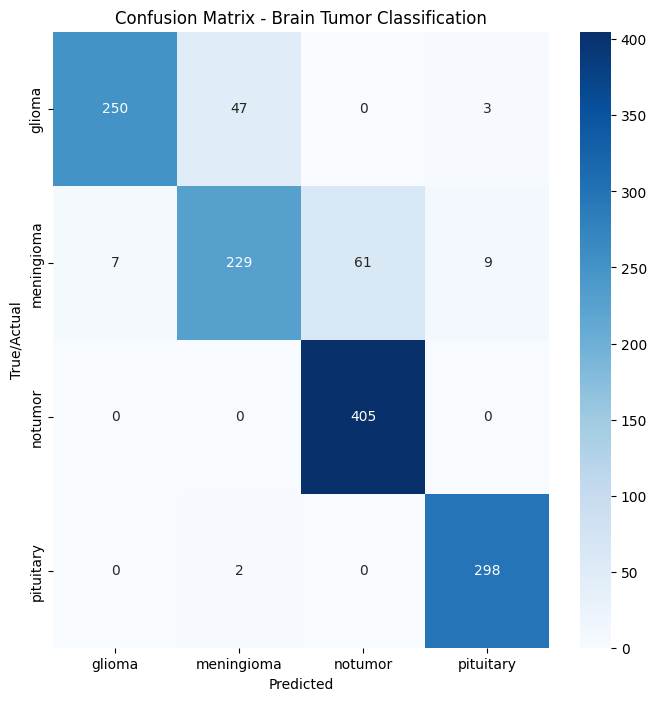

In [9]:
# 1. INITIALIZE THE LOADERS
_, val_loader = get_data_loaders()

# 2. Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)

# 3. Load the saved weights, below is config of saved model
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH)) 
model.eval()

y_true = []
y_pred = []

print("Generating predictions for Confusion Matrix...")

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 4. Plot
plot_confusion_matrix(y_true, y_pred)

### Final Evaluation

In [10]:
### Final Evaluation

# 1. Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)

# 2. Load the Best Saved Model
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH)) 

# 3. Get the Loader
_, test_loader = get_data_loaders()

print("Running Final Evaluation on Test Set...\n")

# 4. Run the Report
print_evaluation_report(model, test_loader, device)

Training labels distribution: [1321 1339 1595 1457]
Running Final Evaluation on Test Set...

---- Classification Report ----
              precision    recall  f1-score   support

      glioma       0.97      0.83      0.90       300
  meningioma       0.82      0.75      0.78       306
     notumor       0.87      1.00      0.93       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.90      1311
   macro avg       0.91      0.89      0.90      1311
weighted avg       0.90      0.90      0.90      1311

